In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm, gamma, expon, lognorm, chi2, kstest, anderson
import warnings
warnings.filterwarnings('ignore')

### 3.4 Actividad final: Simulación relacionada con su pregunta de investigación

Para completar este notebook, realice una simulación estadística que se relacione con su potencial pregunta de investigación. Esta simulación debe:

1. Generar datos que modelen el fenómeno que quieren estudiar
2. Aplicar una prueba estadística apropiada
3. Interpretar los resultados en el contexto de su proyecto

In [15]:
# Cargamos los datos (usamos una muestra para este notebook)
# En caso de que no funcione la carga directa, ajustar la ruta al archivo
import polars as pl

try:
    columnas_fecha = ["FECHA_NACIMIENTO", "FECHA_INGRESO", "FECHAALTA"]
    df = pl.scan_csv("data/GRD_2023_muestra_cancer_UCV.csv", null_values=["DESCONOCIDO"])
    df = df.with_columns([
        pl.coalesce([
            pl.col(col).str.strptime(pl.Date, "%d-%m-%Y", strict=False),
            pl.col(col).str.strptime(pl.Date, "%Y-%m-%d", strict=False)
        ]).alias(col)  # 
        for col in columnas_fecha
    ])
    # Finalmente, materializamos el DataFrame en memoria (si usas lazy):
    df = df.collect()
    grd_data = df.to_pandas()
    print("CSV CARGADO")

except:
    # Este es un dataset simulado para el notebook en caso de no tener acceso al archivo real
    # Solo para fines didácticos
    n_samples = 1000
    grd_data = pd.DataFrame({
        'COD_HOSPITAL': np.random.randint(100000, 200000, n_samples),
        'CIP_ENCRIPTADO': np.random.randint(1000000, 9000000, n_samples),
        'SEXO': np.random.choice(['M', 'F'], n_samples),
        'FECHA_NACIMIENTO': [pd.Timestamp('1940-01-01') + 
                            pd.Timedelta(days=np.random.randint(0, 365*70)) for _ in range(n_samples)],
        'SERVICIO_SALUD': np.random.choice(['METROPOLITANO CENTRAL', 'METROPOLITANO NORTE', 
                                          'METROPOLITANO SUR', 'METROPOLITANO ORIENTE'], n_samples),
        'TIPO_INGRESO': np.random.choice(['URGENCIA', 'ELECTIVO'], n_samples),
        'FECHA_INGRESO': [pd.Timestamp('2023-01-01') + 
                          pd.Timedelta(days=np.random.randint(0, 364)) for _ in range(n_samples)],
        'FECHAALTA': [pd.Timestamp('2023-01-01') + 
                     pd.Timedelta(days=np.random.randint(1, 365)) for _ in range(n_samples)],
        'TIPOALTA': np.random.choice(['DOMICILIO', 'TRASLADO', 'FALLECIMIENTO'], 
                                   n_samples, p=[0.8, 0.15, 0.05]),
        'DIAGNOSTICO1': np.random.choice(['C61', 'C67', 'C64', 'C50', 'I10'], 
                                       n_samples, p=[0.3, 0.2, 0.2, 0.2, 0.1]),
        'IR_29301_COD_GRD': np.random.choice([101101, 101102, 101103, 114101, 114102], n_samples),
        'IR_29301_PESO': np.random.uniform(0.5, 3.0, n_samples).astype(str),
        'IR_29301_SEVERIDAD': np.random.choice([0, 1, 2, 3], n_samples),
        'IR_29301_MORTALIDAD': np.random.choice([0, 1, 2, 3], n_samples),
    })
    print("CSV NOT FOUND")

# Mostramos información básica del dataframe
print("Información del dataset GRD:")
print(f"Tamaño: {grd_data.shape[0]} filas, {grd_data.shape[1]} columnas")
print("\nColumnas disponibles:")
for col in grd_data.columns:
    print(f"- {col}")
    
print("\nPrimeras 5 filas:")
grd_data.head()

CSV NOT FOUND
Información del dataset GRD:
Tamaño: 1000 filas, 14 columnas

Columnas disponibles:
- COD_HOSPITAL
- CIP_ENCRIPTADO
- SEXO
- FECHA_NACIMIENTO
- SERVICIO_SALUD
- TIPO_INGRESO
- FECHA_INGRESO
- FECHAALTA
- TIPOALTA
- DIAGNOSTICO1
- IR_29301_COD_GRD
- IR_29301_PESO
- IR_29301_SEVERIDAD
- IR_29301_MORTALIDAD

Primeras 5 filas:


,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,SERVICIO_SALUD,TIPO_INGRESO,FECHA_INGRESO,FECHAALTA,TIPOALTA,DIAGNOSTICO1,IR_29301_COD_GRD,IR_29301_PESO,IR_29301_SEVERIDAD,IR_29301_MORTALIDAD
0,195128,3060838,F,1949-08-06,METROPOLITANO SUR,URGENCIA,2023-12-15,2023-03-31,DOMICILIO,C61,114102,1.2861396328911128,3,2
1,187826,5179359,M,2001-08-21,METROPOLITANO NORTE,ELECTIVO,2023-01-26,2023-08-30,FALLECIMIENTO,C64,114101,0.938797485982893,0,1
2,130006,8480465,F,2008-11-18,METROPOLITANO NORTE,ELECTIVO,2023-07-25,2023-09-13,DOMICILIO,C61,101103,2.674420109038575,0,0
3,156056,2910132,M,1967-10-27,METROPOLITANO SUR,ELECTIVO,2023-10-21,2023-06-22,DOMICILIO,C67,101102,1.5281957662881087,3,3
4,132346,6138601,M,1971-08-09,METROPOLITANO ORIENTE,ELECTIVO,2023-10-29,2023-05-02,DOMICILIO,C64,101103,1.735207473345209,1,3


In [16]:
grd_data[["IR_29301_MORTALIDAD", "SEXO", "FECHA_NACIMIENTO", "FECHA_INGRESO", "FECHAALTA"]].head()
grd_data["SERVICIO_SALUD"].value_counts()

SERVICIO_SALUD
METROPOLITANO SUR        272
METROPOLITANO NORTE      254
METROPOLITANO CENTRAL    250
METROPOLITANO ORIENTE    224
Name: count, dtype: int64

## Simulacion

In [17]:

print("SIMULACIÓN DE DATOS PARA ANÁLISIS DE MORTALIDAD POR SERVICIO")

#Primero hacemos una simulacion levantando los siuientes datos:
#-Mortalidad x
#-Dias estancia x
#-Enfermedad x
#-Servicio_Salud 
#-Paciente

# 1. Simulamos datos
#np.random.seed(123)
n = 2000  # número de pacientes

# Severidad como variable categórica (0, 1, 2, 3)
mortalidad = np.random.choice([0, 1, 2, 3], size=n, p=[0.2, 0.3, 0.3, 0.2])

# Días de estancia que aumentan con la severidad (simulando una relación)
# Usamos diferentes parámetros de distribución gamma para cada nivel de severidad
dias_estancia = np.zeros(n)
for i in range(n):
    if mortalidad[i] == 0:
        dias_estancia[i] = np.random.gamma(shape=1.5, scale=2, size=1)
    elif mortalidad[i] == 1:
        dias_estancia[i] = np.random.gamma(shape=2, scale=2.5, size=1)
    elif mortalidad[i] == 2:
        dias_estancia[i] = np.random.gamma(shape=3, scale=3, size=1)
    else:  # severidad 3
        dias_estancia[i] = np.random.gamma(shape=4, scale=4, size=1)
#Enfermedad
enfermedad= np.empty(n, dtype=object)
for i in range(n):
    if mortalidad[i] == 0:
        enfermedad[i] = np.random.choice(["Resfriado","sinusitis","sarampion","varicela"],p=[0.4,0.3,0.2,0.1])
    elif mortalidad[i] == 1:
        enfermedad[i] = np.random.choice(["Hypotiroidismo","Hypertiroidismo","Gripe","viruela(Vacunados)"],p=[0.4,0.3,0.2,0.1])
    elif mortalidad[i] == 2:
        enfermedad[i] = np.random.choice(["Diarrea","Diabetes","Colealitis","Pneumonia"],p=[0.4,0.3,0.2,0.1])
    else:  # severidad 3
        enfermedad[i] = np.random.choice(["Paro Cardiaco","Derrame Cerebral","Tuberculosis","Cirrosis hepática"],p=[0.4,0.3,0.2,0.1])

#Servicios salud
sevs=["METROPOLITANA","VALDIVIA","VIÑA DEL MAR","PUERTO MONTT","PUERTO VARAS"]
servicio_salud= np.empty(n, dtype=object)
for i in range(n):
    if np.random.randint(0,1)==0:
        servicio_salud[i]= np.random.choice(sevs,p=[0.4,0.2,0.2,0.1,0.1])
    else:
         servicio_salud[i]= np.random.choice(sevs,p=[0.4,0.2,0.2,0.1,0.1])

paciente= np.empty(n, dtype=object)
for i in range(n):
    paciente[i] = np.random.randint(1000000, 3000000)   

# Creamos un DataFrame
sim_data = pd.DataFrame({
    'Mortalidad': mortalidad,
    'Dias_estancia': dias_estancia,
    'Enfermedad': enfermedad,
    'Servicio_Salud': servicio_salud,
    'ID_Pacienete': paciente,

    'Mortalidad_cat': pd.Categorical(mortalidad, categories=[0, 1, 2, 3], 
                                    ordered=True).map({0: 'Sin gravedad', 1: 'Menor', 
                                                     2: 'Moderada', 3: 'Mayor'})
})

sim_data

SIMULACIÓN DE DATOS PARA ANÁLISIS DE MORTALIDAD POR SERVICIO


,Mortalidad,Dias_estancia,Enfermedad,Servicio_Salud,ID_Pacienete,Mortalidad_cat
0,1,8.801012,viruela(Vacunados),PUERTO VARAS,1527156,Menor
1,1,4.890555,Hypertiroidismo,METROPOLITANA,1719247,Menor
2,2,2.204124,Diarrea,VIÑA DEL MAR,1996406,Moderada
3,1,4.728482,Hypertiroidismo,VALDIVIA,1521363,Menor
4,2,7.983036,Diarrea,PUERTO MONTT,2125018,Moderada
...,...,...,...,...,...,...
1995,0,2.369485,varicela,METROPOLITANA,1848070,Sin gravedad
1996,0,6.728901,Resfriado,VIÑA DEL MAR,2992947,Sin gravedad
1997,2,7.981420,Colealitis,METROPOLITANA,1879510,Moderada
1998,0,1.269671,Resfriado,VIÑA DEL MAR,1001415,Sin gravedad


In [18]:
sim_data["Servicio_Salud"].value_counts()

Servicio_Salud
METROPOLITANA    806
VIÑA DEL MAR     395
VALDIVIA         388
PUERTO VARAS     210
PUERTO MONTT     201
Name: count, dtype: int64

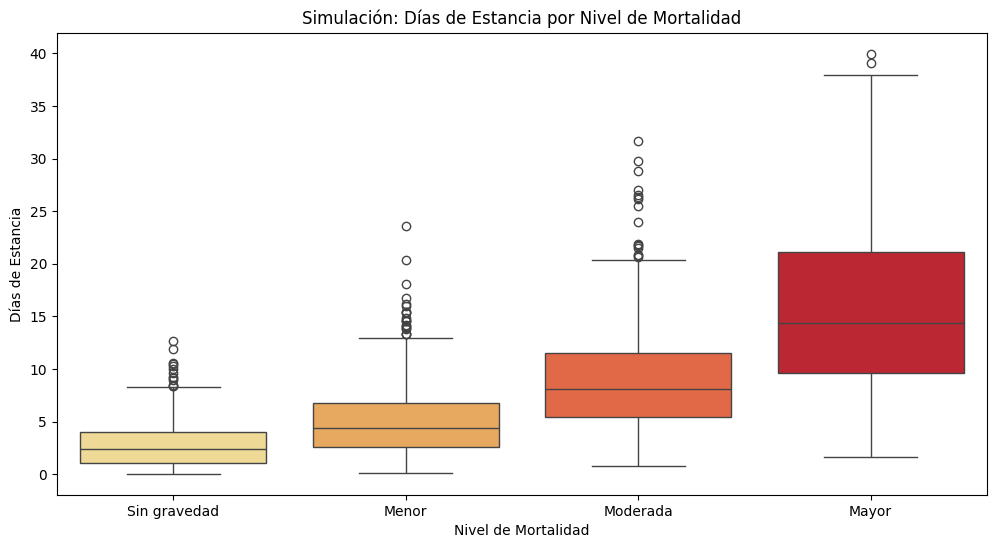

Resultados del ANOVA:
Estadístico F: 544.8911
p-valor: 0.0000
Conclusión: Hay diferencias significativas entre los grupos

Estadísticas descriptivas por nivel de severidad:


,count,mean,std,min,25%,50%,75%,max
Mortalidad_cat,,,,,,,,
Sin gravedad,393.0,2.872767,2.313075,0.054985,1.103052,2.369485,3.992532,12.643849
Menor,620.0,5.112897,3.434048,0.147445,2.605185,4.355288,6.784519,23.607662
Moderada,595.0,8.957229,4.898422,0.748126,5.460767,8.103945,11.531912,31.699692
Mayor,392.0,15.649337,7.820514,1.611638,9.595442,14.378815,21.154304,39.962107


In [19]:
# 2. Visualizamos la relación
plt.figure(figsize=(12, 6))
sns.boxplot(x='Mortalidad_cat', y='Dias_estancia', data=sim_data, palette='YlOrRd')
plt.title('Simulación: Días de Estancia por Nivel de Mortalidad')
plt.xlabel('Nivel de Mortalidad')
plt.ylabel('Días de Estancia')
plt.show()

# 3. Análisis estadístico: ANOVA para comparar medias entre grupos
from scipy.stats import f_oneway

# Separamos los grupos
grupo0 = sim_data[sim_data['Mortalidad'] == 0]['Dias_estancia']
grupo1 = sim_data[sim_data['Mortalidad'] == 1]['Dias_estancia']
grupo2 = sim_data[sim_data['Mortalidad'] == 2]['Dias_estancia']
grupo3 = sim_data[sim_data['Mortalidad'] == 3]['Dias_estancia']

# Realizamos ANOVA
f_stat, p_valor = f_oneway(grupo0, grupo1, grupo2, grupo3)

print(f"Resultados del ANOVA:")
print(f"Estadístico F: {f_stat:.4f}")
print(f"p-valor: {p_valor:.4f}")
print(f"Conclusión: {'Hay diferencias significativas entre los grupos' if p_valor < 0.05 else 'No hay diferencias significativas entre los grupos'}")

# 4. Resumen descriptivo por grupo
print("\nEstadísticas descriptivas por nivel de severidad:")
display(sim_data.groupby('Mortalidad_cat')['Dias_estancia'].describe())

# Su turno: Modifique este ejemplo o cree una nueva simulación
# relacionada con su pregunta de investigación

In [20]:
df = pd.read_csv("data\GRD_2023_muestra_cancer_UCV_limpio.csv")

In [21]:
df

,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,SERVICIO_SALUD,TIPO_INGRESO,FECHA_INGRESO,FECHAALTA,TIPOALTA,DIAGNOSTICO1,IR_29301_COD_GRD,IR_29301_PESO,IR_29301_SEVERIDAD,IR_29301_MORTALIDAD,TIPO_FECHA_NACIMIENTO,TIPO_FECHA_INGRESO,TIPO_FECHAALTA,EDAD,DIAS_ESTANCIA
0,122100,72196813,HOMBRE,1980-04-13,VALDIVIA,URGENCIA,2023-03-12,2023-03-14,DOMICILIO,K35.3,064161,0.7094,1.0,1.0,YMD,DMY,DMY,43.0,2
1,114101,DESCONOCIDO,HOMBRE,2001-11-04,METROPOLITANO SURORIENTE,URGENCIA,2023-11-04,2023-11-10,DOMICILIO,J93.1,041301,1.0869,1.0,1.0,YMD,DMY,DMY,22.0,6
2,114101,97627974,HOMBRE,2020-07-30,METROPOLITANO SURORIENTE,URGENCIA,2023-06-07,2023-06-08,HOSPITALIZACIÓN DOMICILIARIA,J12.1,044161,0.4084,1.0,1.0,YMD,DMY,DMY,3.0,1
3,106103,67770674,MUJER,1978-11-14,VALPARAISO SAN ANTONIO,PROGRAMADA,2023-05-25,2023-05-26,DOMICILIO,N39.3,131301,0.6406,1.0,1.0,YMD,DMY,DMY,45.0,1
4,106103,100390800,MUJER,2023-12-20,VALPARAISO SAN ANTONIO,URGENCIA,2023-12-28,2023-12-30,DOMICILIO,R17,074131,0.5346,1.0,1.0,YMD,DMY,DMY,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039582,105102,78111817,MUJER,1995-12-06,COQUIMBO,OBSTETRICA,2023-01-01,2023-01-04,DOMICILIO,O03.1,131111,0.5227,1.0,1.0,YMD,DMY,DMY,27.0,3
1039583,118100,76593606,MUJER,1991-04-26,CONCEPCIÓN,PROGRAMADA,2023-06-14,2023-06-14,DOMICILIO,N87.1,132340,0.1761,0.0,0.0,YMD,DMY,DMY,32.0,0
1039584,115100,100360940,HOMBRE,2015-01-08,LIBERTADOR B. O HIGGINS,URGENCIA,2023-11-29,2023-12-01,DOMICILIO,K35.8,061131,0.7398,1.0,1.0,YMD,DMY,DMY,9.0,2
1039585,123100,78557002,HOMBRE,2014-01-07,OSORNO,PROGRAMADA,2023-03-28,2023-03-28,DOMICILIO,J45.0,044181,0.3452,1.0,1.0,YMD,DMY,DMY,9.0,0


In [22]:
estancia = df["DIAS_ESTANCIA"]

# Medidas de tendencia central
media = estancia.mean()
mediana = estancia.median()
moda = estancia.mode()[0]

# Medidas de dispersión
desviacion_estandar = estancia.std()
rango = estancia.max() - estancia.min()
percentiles = estancia.quantile([0.25, 0.5, 0.75])

# Resultados
print("Medidas de tendencia central:")
print("Media :", media)
print("Media :", mediana)
print("Moda :", moda)

print("\nMedidas de dispersión:")
print("Desviacion_estandar :", desviacion_estandar)
print("Rango :", rango)
print("Quartiles (25%, 50%, 75%) :")
print(percentiles)

Medidas de tendencia central:
Media : 5.796219075459774
Media : 2.0
Moda : 0

Medidas de dispersión:
Desviacion_estandar : 12.348311332187649
Rango : 696
Quartiles (25%, 50%, 75%) :
0.25    1.0
0.50    2.0
0.75    6.0
Name: DIAS_ESTANCIA, dtype: float64


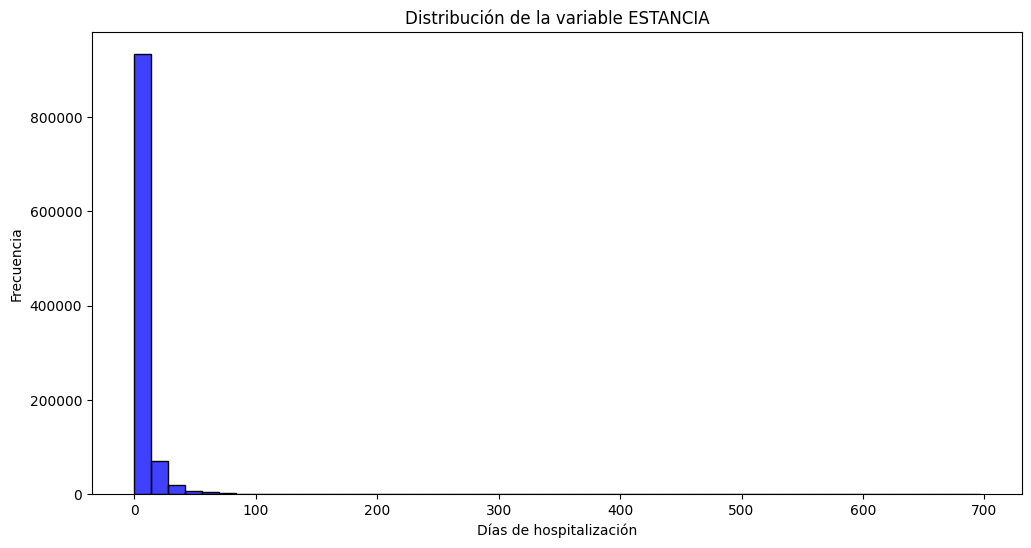

In [23]:
# Histograma
plt.figure(figsize=(12, 6))
sns.histplot(estancia, bins=50, color='blue')
plt.title('Distribución de la variable ESTANCIA')
plt.xlabel('Días de hospitalización')
plt.ylabel('Frecuencia')
plt.show()

In [24]:
# Eliminaremos datos atipicos con el método IQR (Rango Intercuartílico)
Q1 = estancia.quantile(0.25)
Q3 = estancia.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print("Los limites son :", limite_inferior, limite_superior)
no_outliers = df[((df["DIAS_ESTANCIA"] > limite_inferior) & (df["DIAS_ESTANCIA"] < limite_superior))]

Los limites son : -6.5 13.5


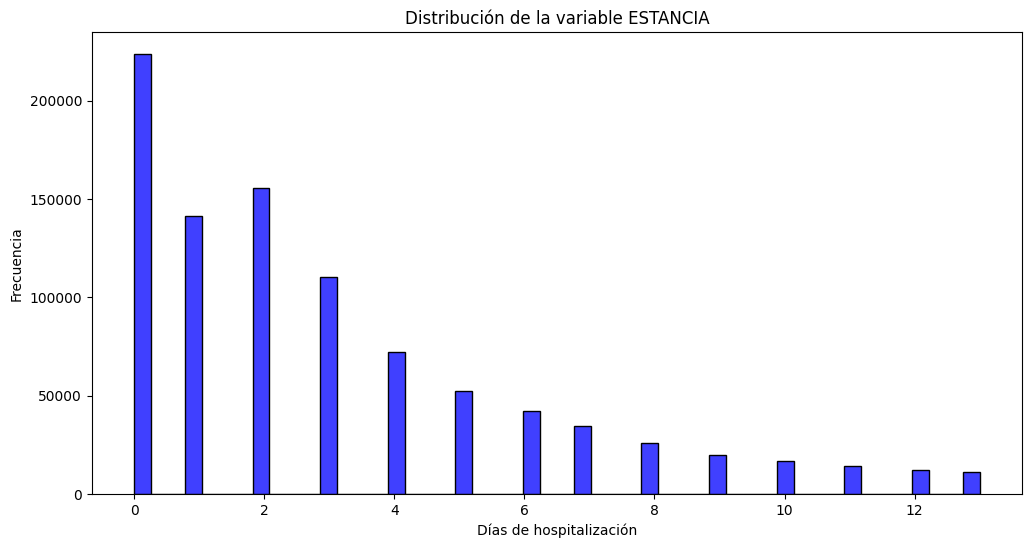

In [34]:
# Histograma
plt.figure(figsize=(12, 6))
sns.histplot(no_outliers["DIAS_ESTANCIA"], bins=50, color='blue')
plt.title('Distribución de la variable ESTANCIA')
plt.xlabel('Días de hospitalización')
plt.ylabel('Frecuencia')
plt.show()

## Calculamos el intervalo de confianza usando muestras de distintos tamaños

In [26]:
len(no_outliers)

933239

In [27]:
media_global = no_outliers["DIAS_ESTANCIA"].mean()

In [28]:
tamaño_muestras = [1000, 5000, 10000, 15000, 20000]

In [29]:
for i in tamaño_muestras:
    muestra = np.random.choice(no_outliers["DIAS_ESTANCIA"], size=i, replace=False)
    n = len(muestra)
    media = np.mean(muestra)
    desv_est = np.std(muestra, ddof=1)
    error_estandar = desv_est / np.sqrt(n)
    confianza = 0.95
    grados_libertad = n - 1
    valor_t = stats.t.ppf((1 + confianza) / 2, grados_libertad)

    # Cálculo del intervalo
    margen_error = valor_t * error_estandar
    intervalo_inferior = media - margen_error
    intervalo_superior = media + margen_error

    print(i)
    print(f"Media muestral: {media:.2f} días")
    print(f"Intervalo de confianza del 95%: ({intervalo_inferior:.2f}, {intervalo_superior:.2f}) días, el 95 porciento de las veces caeremos entre ({intervalo_inferior:.2f}, {intervalo_superior:.2f})")
    print(f"¿El intervalo contiene la media poblacional ({media_global:.2f})? {intervalo_inferior <= media_global <= intervalo_superior}")

1000
Media muestral: 3.04 días
Intervalo de confianza del 95%: (2.84, 3.23) días, el 95 porciento de las veces caeremos entre (2.84, 3.23)
¿El intervalo contiene la media poblacional (3.04)? True
5000
Media muestral: 2.94 días
Intervalo de confianza del 95%: (2.86, 3.03) días, el 95 porciento de las veces caeremos entre (2.86, 3.03)
¿El intervalo contiene la media poblacional (3.04)? False
10000
Media muestral: 3.07 días
Intervalo de confianza del 95%: (3.01, 3.14) días, el 95 porciento de las veces caeremos entre (3.01, 3.14)
¿El intervalo contiene la media poblacional (3.04)? True
15000
Media muestral: 3.00 días
Intervalo de confianza del 95%: (2.95, 3.05) días, el 95 porciento de las veces caeremos entre (2.95, 3.05)
¿El intervalo contiene la media poblacional (3.04)? True
20000
Media muestral: 3.03 días
Intervalo de confianza del 95%: (2.99, 3.07) días, el 95 porciento de las veces caeremos entre (2.99, 3.07)
¿El intervalo contiene la media poblacional (3.04)? True


una muestra aleatoria de 15000 datos es lo suficientemente representativa para  

In [33]:
muestra = np.random.choice(no_outliers["DIAS_ESTANCIA"], size=15000, replace=False)
muestra

array([2, 6, 0, ..., 2, 4, 1])